In [ ]:
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten

In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train, x_test = x_train / 255.0, x_test / 255.0



11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),  # Flatten the input images
    Dense(128, activation='relu'),   # Fully connected layer with 128 neurons
    Dense(10, activation='softmax')  # Output layer with 10 neurons (for 10 classes)
])


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2566 - accuracy: 0.9262 - val_loss: 0.1405 - val_accuracy: 0.9581
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1129 - accuracy: 0.9664 - val_loss: 0.0954 - val_accuracy: 0.9711
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0764 - accuracy: 0.9770 - val_loss: 0.0935 - val_accuracy: 0.9706
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0586 - accuracy: 0.9823 - val_loss: 0.0759 - val_accuracy: 0.9767
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0453 - accuracy: 0.9864 - val_loss: 0.0825 - val_accuracy: 0.9749


In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)


313/313 [==============================] - 1s 2ms/step - loss: 0.0825 - accuracy: 0.9749
Test accuracy: 0.9749000072479248


1/1 [==============================] - 0s 18ms/step


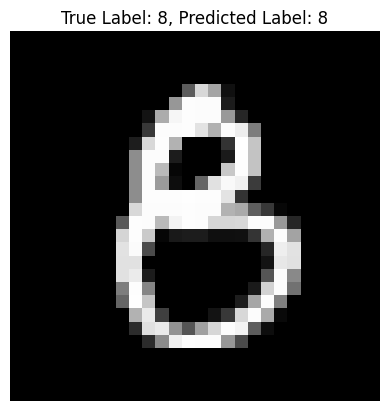

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load a sample image for prediction (you can replace this with your own image)
sample_image_index = 800
sample_image = x_test[sample_image_index]
sample_label = y_test[sample_image_index]

# Reshape the image to match the input shape of the model
sample_image = np.expand_dims(sample_image, axis=0)

# Make prediction
predictions = model.predict(sample_image)

# Get the predicted label (class with highest probability)
predicted_label = np.argmax(predictions)

# Show original image
plt.imshow(sample_image.squeeze(), cmap='gray')
plt.axis('off')
plt.title(f'True Label: {sample_label}, Predicted Label: {predicted_label}')
plt.show()


# **Starting**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:48<00:00, 23.7MB/s]
100% 1.04G/1.04G [00:48<00:00, 22.8MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
dataset_dir = 'flickr8k'

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, RepeatVector, TimeDistributed, Conv2D, MaxPooling2D, Flatten, Input, concatenate



In [ ]:
# Path to the captions.txt file
captions_file_path = '/content/captions.txt'

# Read the contents of captions.txt file
captions = []

with open(captions_file_path, 'r') as f:
    captions = f.readlines()

# Initialize a dictionary to store image filenames and their corresponding captions
image_captions = {}

# Path to the Images directory
images_directory = '/content/Images'

# Iterate through the images directory
for filename in os.listdir(images_directory):
    if filename.endswith('.jpg'):  # Assuming images are JPEG files
        # Construct the full path to the image file
        image_path = os.path.join(images_directory, filename)

        # Assign the first five captions to the image
        image_captions[image_path] = [caption.strip() for caption in captions[:5]]

        # Remove the first five captions from the list
        captions = captions[5:]

# Convert the dictionary to lists of image filenames and corresponding captions
image_filenames = list(image_captions.keys())
captions = list(image_captions.values())

In [ ]:
# Preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))  # Resize image to 224x224
    img = img_to_array(img) / 255.0  # Normalize pixel values to range [0, 1]
    return img

In [ ]:
# Preprocess captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
sequences = tokenizer.texts_to_sequences(captions)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


In [ ]:
# Print the number of image filenames and padded sequences
print("Number of image filenames:", len(image_filenames))
print("Number of padded sequences:", len(padded_sequences))

Number of image filenames: 8091
Number of padded sequences: 8091


In [ ]:
# Split the data into training and testing sets
train_image_filenames, test_image_filenames, train_captions, test_captions = \
    train_test_split(image_filenames, padded_sequences, test_size=0.2, random_state=42)


In [ ]:
# Load and preprocess images
batch_size = 8
train_images = np.array([preprocess_image(image) for image in train_image_filenames[:batch_size]])
test_images = np.array([preprocess_image(image) for image in test_image_filenames])

In [ ]:
from keras.applications import VGG16
from keras.layers import Input, Flatten, Dense, LSTM, Embedding, concatenate
from keras.models import Model

# Load pre-trained VGG16 model (excluding the top layer)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the VGG16 model
for layer in vgg16.layers:
    layer.trainable = False

# Define the input layers
image_input = Input(shape=(128, 128, 3))
caption_input = Input(shape=(max_sequence_length,))

# Get the image features from VGG16
image_features = vgg16(image_input)
image_features = Flatten()(image_features)

# LSTM part for text processing
embedding_dim = 256
lstm_units = 256

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(caption_input)
lstm_output = LSTM(units=lstm_units)(embedding_layer)

58889256/58889256 [==============================] - 4s 0us/step


#Takes too much load here and crashes ⬇


In [ ]:
# Combine image and text features
combined_features = concatenate([image_features, lstm_output])

# Output layer
output = Dense(vocab_size, activation='softmax')(combined_features)

In [ ]:
# Create the model
model = Model(inputs=[image_input, caption_input], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 4, 4, 512)            1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 embedding (Embedding)       (None, 5, 256)               1035315   ['input_3[0][0]']         

### Number of text and images are not same.Check it, if both are not same, this code will not work

In [ ]:
# Path to the captions.txt file
captions_file_path = '/content/captions.txt'

# Read the contents of captions.txt file
captions = []

with open(captions_file_path, 'r') as f:
    captions = f.readlines()

# Initialize a dictionary to store image filenames and their corresponding captions
image_captions = {}

# Path to the Images directory
images_directory = '/content/Images'

# Iterate through the images directory
for filename in os.listdir(images_directory):
    if filename.endswith('.jpg'):  # Assuming images are JPEG files
        # Construct the full path to the image file
        image_path = os.path.join(images_directory, filename)

        # Assign the first five captions to the image
        image_captions[image_path] = [caption.strip() for caption in captions[:5]]

        # Remove the first five captions from the list
        captions = captions[5:]


In [ ]:
print("Shape of train_images:", train_images.shape)
print("Shape of train_captions:", train_captions.shape)


Shape of train_images: (0, 128, 128, 3)
Shape of train_captions: (0, 5)


In [ ]:
# Preprocess images
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(128, 128))  # Resize image to 128x128
    img = img_to_array(img) / 255.0  # Normalize pixel values to range [0, 1]
    return img

# Preprocess captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
sequences = tokenizer.texts_to_sequences(captions)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


In [ ]:
print("Number of sequences:", len(sequences))
print("Max sequence length:", max_sequence_length)
print("Example sequence:", sequences[0])
print("Example padded sequence:", padded_sequences[0])


Number of sequences: 1
Max sequence length: 12
Example sequence: [3, 4, 5, 1, 2, 6, 7, 8, 1, 2, 9, 10]
Example padded sequence: [ 3  4  5  1  2  6  7  8  1  2  9 10]


In [ ]:
# Check if train_images is not empty
if len(train_images) > 0:
    # Create a TensorFlow dataset from your input data
    dataset = tf.data.Dataset.from_tensor_slices((train_images, train_captions, target_captions))
    dataset = dataset.shuffle(buffer_size=len(train_images)).batch(batch_size)

    # Define a custom training step function
    @tf.function
    def train_step(images, captions, target_captions):
        with tf.GradientTape() as tape:
            predictions = model([images, captions], training=True)
            loss = loss_function(target_captions, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # Define your loss function and optimizer
    loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()

    # Training loop
    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0
        for batch_images, batch_captions, batch_target_captions in dataset:
            loss = train_step(batch_images, batch_captions, batch_target_captions)
            total_loss += loss


In [ ]:
print("Shape of train_images:", train_images.shape if train_images is not None else "Data is empty")
print("Shape of train_captions:", train_captions.shape if train_captions is not None else "Data is empty")
print("Length of train_images:", len(train_images) if train_images is not None else "Data is empty")
print("Length of train_captions:", len(train_captions) if train_captions is not None else "Data is empty")


Shape of train_images: (0, 128, 128, 3)
Shape of train_captions: (0, 5)
Length of train_images: 0
Length of train_captions: 0


In [ ]:
 # Train the model
batch_size = 32
epochs = 10

model.fit([train_images, train_captions], train_captions, epochs=epochs, batch_size=batch_size)


ValueError: Expected input data to be non-empty.

In [ ]:
# Evaluate the model
loss = model.evaluate([test_images, test_captions], test_captions, batch_size=batch_size)
print("Test Loss:", loss)

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-17-bf2c7016b9ff>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [32,40442] and labels shape [160]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_2384]

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:04<00:00, 254MB/s]
100% 1.04G/1.04G [00:04<00:00, 241MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/flickr8k.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
BASE_DIR = '/content/flickr8k'
WORKING_DIR = '/content/working'

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [ ]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

# Load the captions data

In [ ]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [ ]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

#Preprocess the data

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# preprocess the text
clean(mapping)

In [ ]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train test split

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

# Model creation

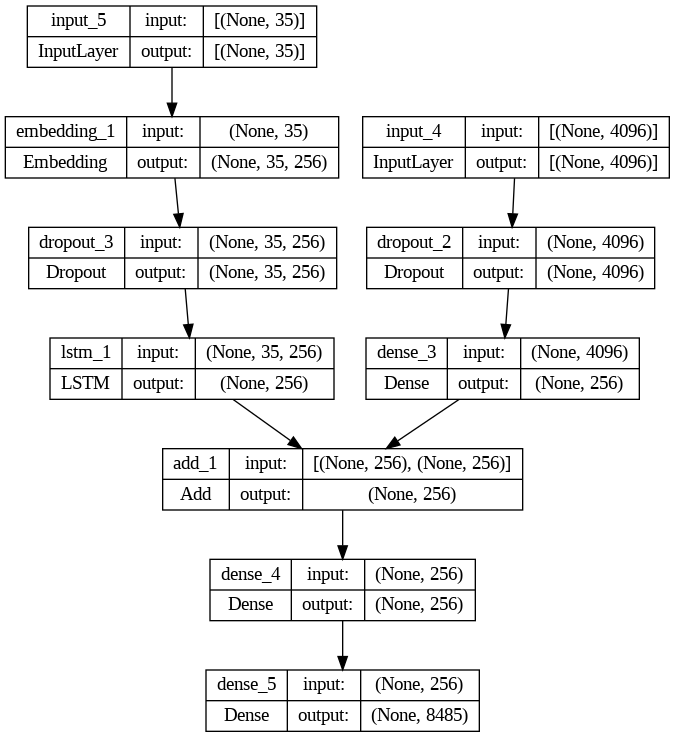

In [ ]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# plot the model
plot_model(model, show_shapes=True)


In [ ]:
# train the model
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 58s 255ms/step - loss: 2.6181 - accuracy: 0.3802


In [ ]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Generate captions for the image

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.551214
BLEU-2: 0.324221


# Visualize the result

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs are playing with plastic bag on the sand endseq


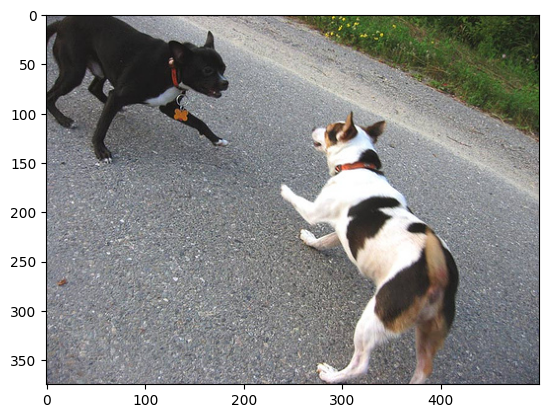

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg")

#Test with real image

In [ ]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

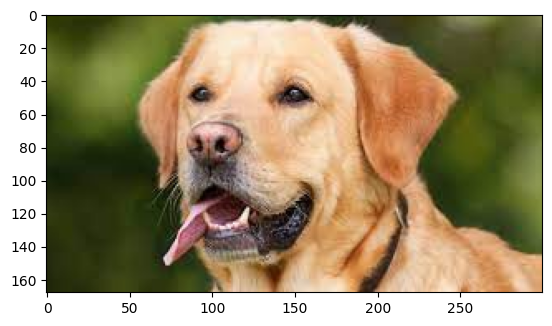

In [ ]:
import matplotlib.pyplot as plt
im = plt.imread('/content/dog.jpeg')
plt.imshow(im)
plt.show()

In [ ]:
image_path = '/content/dog.jpeg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)


'startseq dog chews on red toy endseq'